<img src="img/TS_DNN1.png"/>

<div class="alert alert-block alert-success">
    <b>Problem Statement:</b>In this case study, weekly return of the Microsoft stock is used as the predicted variable. 
We need to understand what affects Microsoft stock price and hence incorporate as much information into the model.

For this case study, other than the historical data of Microsoft, the independent variables used are the following potentially correlated assets:

- Stocks: IBM (IBM) and Alphabet (GOOGL)
- Currency: USD/JPY and GBP/USD
- Indices: S&P 500, Dow Jones and VIX
</div>

<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS">Download/import the relevant packages</span></b>
</div>

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS">Load the data</span></b>
</div>

In [3]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

<div class="alert alert-block alert-success">
Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.
</div>

In [4]:
return_period = 5

<div class="alert alert-block alert-success">
We now define our Y series and our X series

Y: MSFT **Future** Returns

X:List of Independant features

a. <b>GOOGL 5</b> - Business Day Returns
b. <b>IBM 5</b> - Business DayReturns    
c. <b>USD/JPY 5</b> - Business DayReturns    
d. <b>GBP/USD 5</b> - Business DayReturns    
e. <b>S&P 500 5</b> - Business DayReturns    
f. <b>Dow Jones 5</b> - Business DayReturns    
g. <b>MSFT 5</b> - Business Day Returns    
h. <b>MSFT 15</b> - Business Day Returns    
i. <b>MSFT 30</b> - Business Day Returns    
j. <b>MSFT 60</b> - Business Day Returns

We remove the MSFT past returns when we use the Time series models.
</div>

In [5]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_dep'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

df_ts = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = df_ts.loc[:, Y.name]
X = df_ts.loc[:, X.columns]

In [6]:
Y.head()

2016-06-08   -0.046209
2016-06-15    0.025826
2016-06-22   -0.008865
2016-06-29    0.016484
2016-07-07    0.044909
Name: MSFT_dep, dtype: float64

In [7]:
X.head()

,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2016-06-08,-0.007416,0.009723,-0.026547,0.010435,0.009383,0.012034,-0.008487,-0.015445,0.029841,0.018567,-0.014512
2016-06-15,-0.014562,-0.021794,-0.007622,-0.025131,-0.022728,-0.020474,0.357953,-0.046209,-0.037524,0.005160,-0.073615
2016-06-22,-0.030113,0.014757,-0.012451,0.034437,0.006712,0.007942,0.049877,0.025826,-0.035828,0.006382,-0.063447
2016-06-29,-0.021741,-0.029600,-0.018144,-0.083192,-0.007064,-0.004857,-0.240776,-0.008865,-0.029248,0.000594,-0.069566
2016-07-07,0.017213,0.027505,-0.019951,-0.024153,-0.000457,-0.001904,-0.057271,0.016484,0.033445,-0.004079,-0.054731


In [8]:
print(Y.shape)
print(X.shape)

(225,)
(225, 11)


<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS">Exploratory Data Analysis(EDA)</span></b>
</div>

In [9]:
pd.set_option('precision', 3)
df_ts.describe()

,MSFT_dep,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,225.000,225.000,2.250e+02,2.250e+02,2.250e+02,225.000,225.000,225.000,225.000,225.000,225.000,225.000
mean,0.007,0.005,1.605e-04,1.957e-05,-3.488e-04,0.002,0.002,-0.002,0.007,0.020,0.041,0.078
std,0.028,0.034,3.369e-02,1.197e-02,1.478e-02,0.021,0.023,0.168,0.029,0.045,0.055,0.068
min,-0.120,-0.131,-1.569e-01,-3.741e-02,-8.319e-02,-0.131,-0.164,-0.404,-0.120,-0.149,-0.238,-0.116
25%,-0.007,-0.012,-1.462e-02,-6.617e-03,-7.543e-03,-0.004,-0.006,-0.092,-0.009,-0.004,0.012,0.039
50%,0.008,0.008,1.430e-03,3.551e-04,4.009e-04,0.004,0.003,-0.017,0.008,0.023,0.044,0.077
75%,0.022,0.026,1.777e-02,5.788e-03,9.464e-03,0.013,0.012,0.068,0.024,0.042,0.072,0.124
max,0.077,0.089,9.203e-02,4.839e-02,5.530e-02,0.059,0.079,0.992,0.077,0.147,0.244,0.306


In [10]:
df_ts.head()

,MSFT_dep,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2016-06-08,-0.046,-0.007,0.010,-0.027,0.010,9.383e-03,0.012,-0.008,-0.015,0.030,1.857e-02,-0.015
2016-06-15,0.026,-0.015,-0.022,-0.008,-0.025,-2.273e-02,-0.020,0.358,-0.046,-0.038,5.160e-03,-0.074
2016-06-22,-0.009,-0.030,0.015,-0.012,0.034,6.712e-03,0.008,0.050,0.026,-0.036,6.382e-03,-0.063
2016-06-29,0.016,-0.022,-0.030,-0.018,-0.083,-7.064e-03,-0.005,-0.241,-0.009,-0.029,5.938e-04,-0.070
2016-07-07,0.045,0.017,0.028,-0.020,-0.024,-4.575e-04,-0.002,-0.057,0.016,0.033,-4.079e-03,-0.055


<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS">Data Visualization</span></b>
</div>

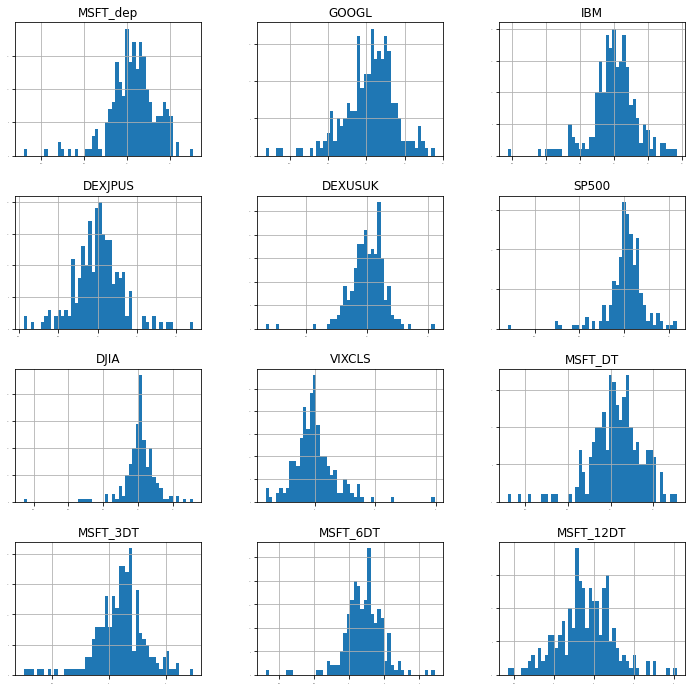

In [11]:
df_ts.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

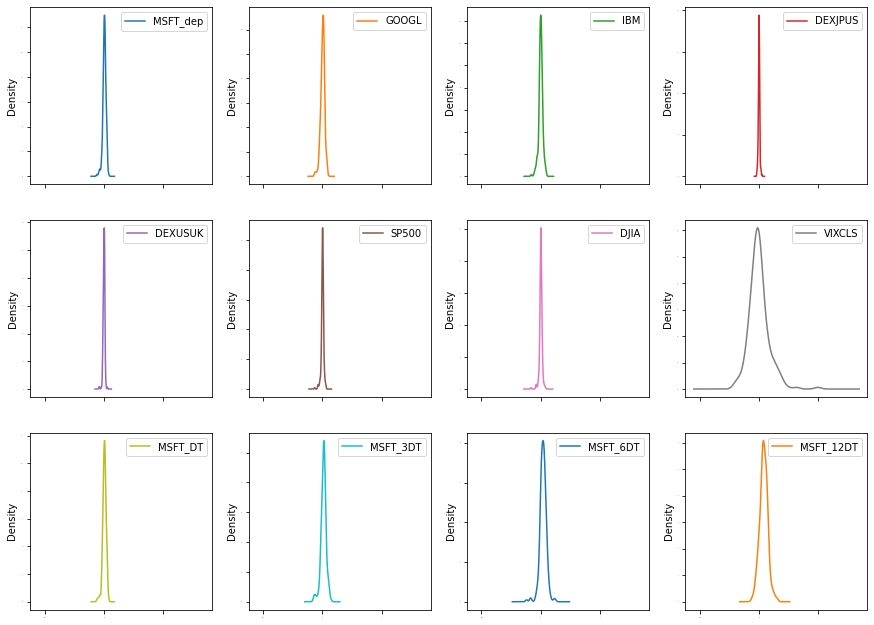

In [12]:
df_ts.plot(kind='density', subplots=True, 
             layout=(4,4), 
             sharex=True, 
             legend=True, 
             fontsize=1, 
             figsize=(15,15))
pyplot.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

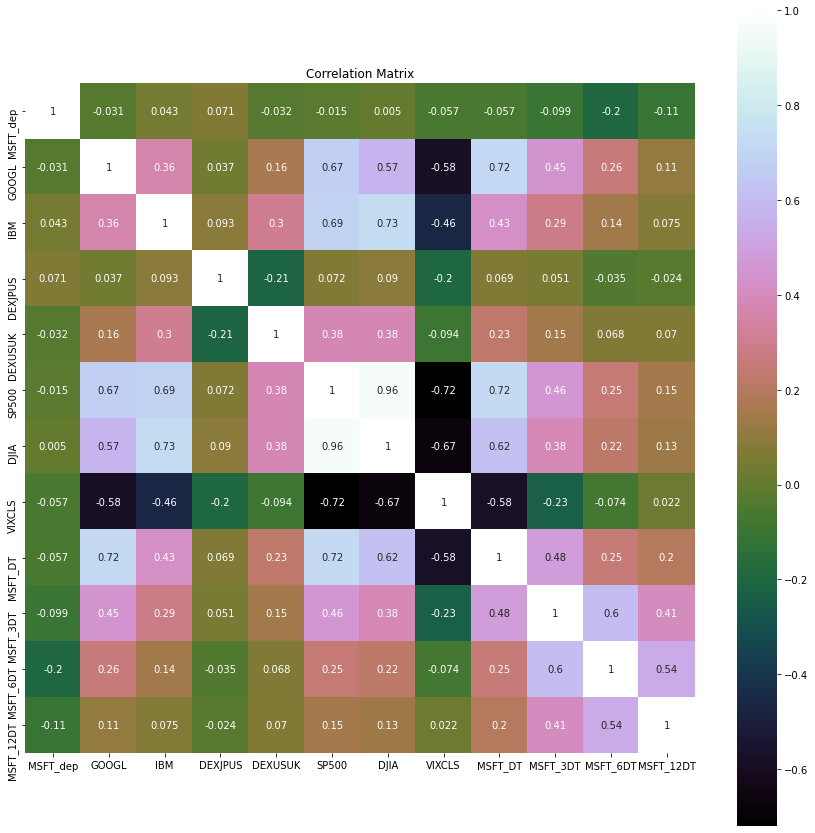

In [13]:
correlation = df_ts.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

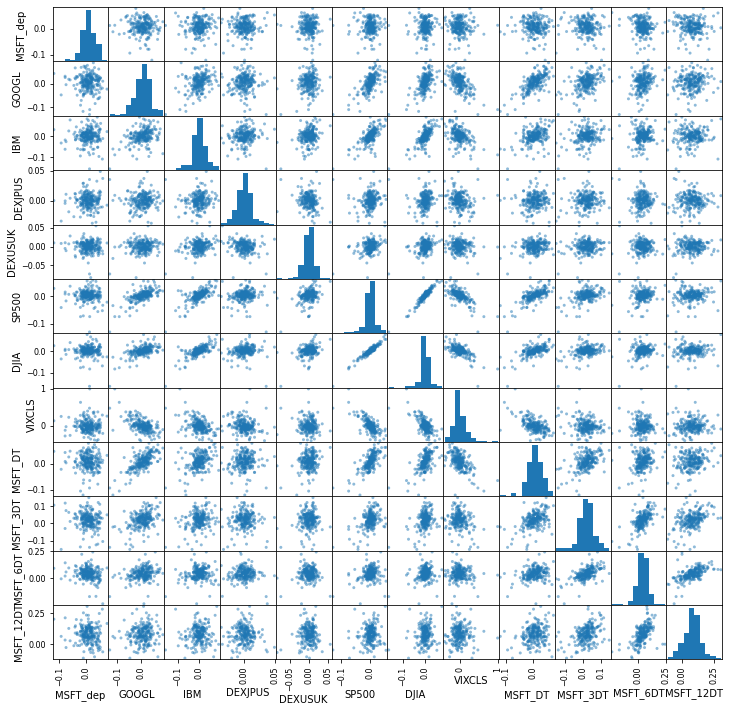

In [14]:
pyplot.figure(figsize=(15,15))
scatter_matrix(df_ts,figsize=(12,12))
pyplot.show()

<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS">Time Series Analysis</span></b>
</div>

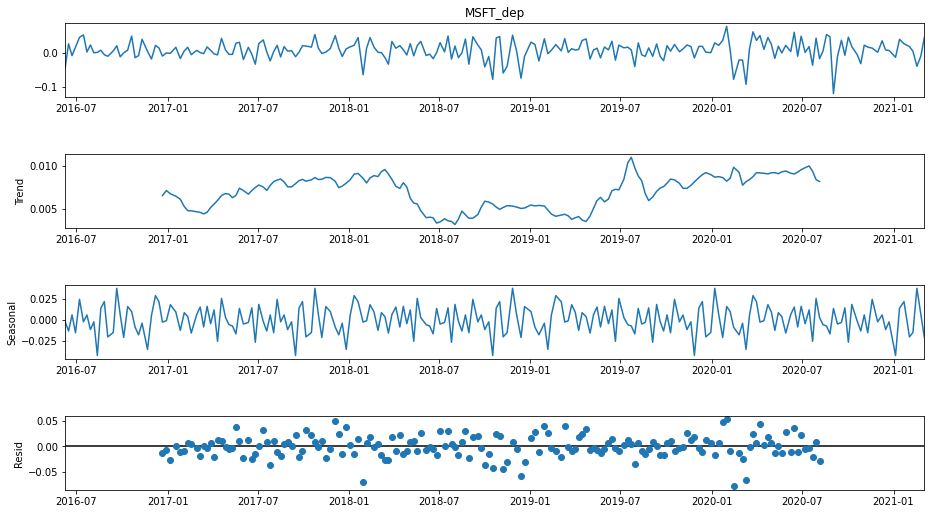

In [15]:
# Additive - Decomposition model
res = sm.tsa.seasonal_decompose(Y,freq=52, model='additive')
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS">Data Preparation and Feature Selection</span></b>
</div>

In [16]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_6DT,9.112
MSFT_12DT,2.601
MSFT_3DT,2.196
DEXJPUS,1.121
VIXCLS,0.736
MSFT_DT,0.722
IBM,0.404
DEXUSUK,0.235
GOOGL,0.217


<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS">Model Development & Evaluation</span></b>
</div>

In [17]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

__Test Options and Evaluation Metrics__

In [18]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

__Compare Models and Algorithms__

___Regression and Tree-based ensemble Regression algorithms___

In [19]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

____Neural Network algorithms____

In [20]:
# Feed-forward NN
models.append(('MLP', MLPRegressor()))

In [21]:
# Performance of each Model
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000736 (0.000572) 0.000641 0.001078
LASSO: 0.000679 (0.000511) 0.000675 0.001100
EN: 0.000679 (0.000511) 0.000675 0.001100
KNN: 0.000818 (0.000565) 0.000540 0.001017
CART: 0.001468 (0.000474) 0.000000 0.002115
SVR: 0.000881 (0.000456) 0.000870 0.001471
ABR: 0.000802 (0.000555) 0.000387 0.001253
GBR: 0.000974 (0.000534) 0.000075 0.001739
RFR: 0.000797 (0.000506) 0.000126 0.001244
ETR: 0.000814 (0.000565) 0.000000 0.001282
MLP: 0.001642 (0.000727) 0.000727 0.001282


____cross-validation results____

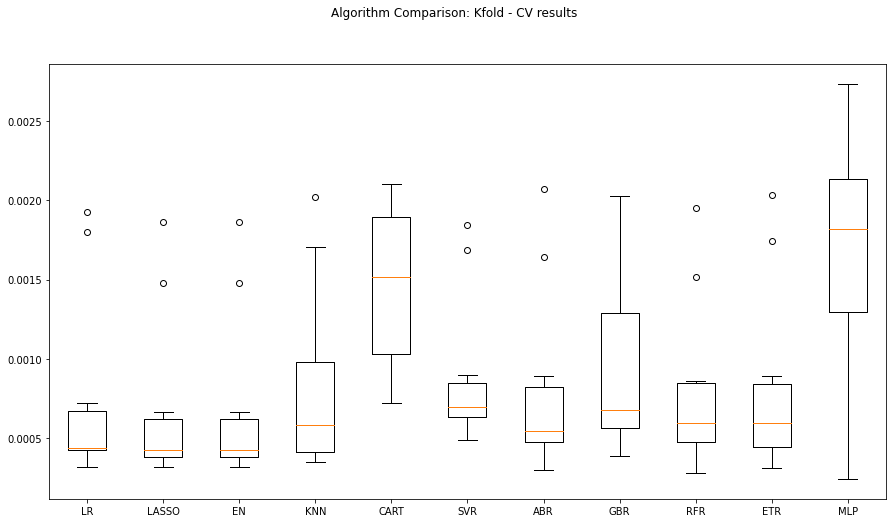

In [22]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold - CV results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

____Comparison of Training and Test Dataset errors____

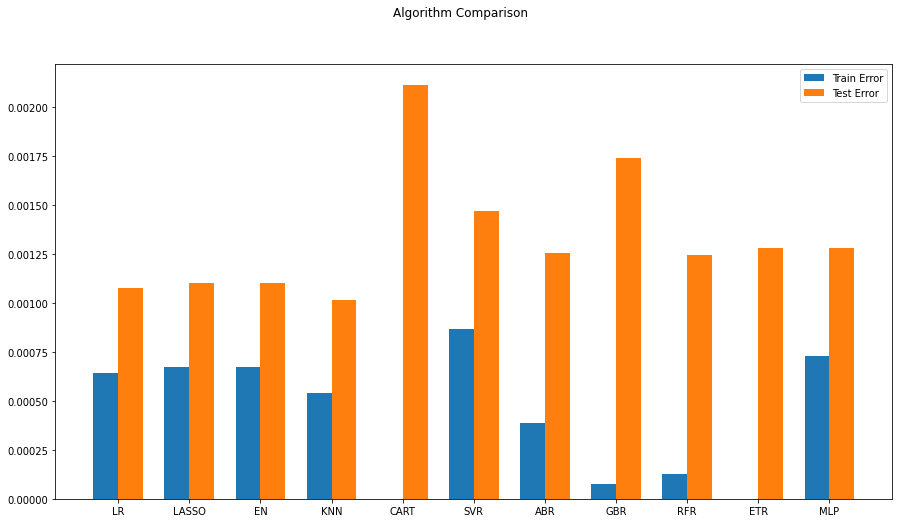

In [23]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

<div class="alert alert-block alert-success">
Looking at the training and test error, we still see a better performance of the linear models. Some of the algorithms, such as the decision tree regressor (CART) overfit on the training data and produced very high error on the test set and these models should be avoided. Ensemble models, such as gradient boosting regression (GBR) and random forest regression (RFR) have low bias but high variance. We also see that the artificial neural network (shown as MLP is the chart) algorithm shows higher errors both in training set and test set, which is perhaps due to the linear relationship of the variables not captured accurately by ANN or improper hyperparameters or insuffi‐ cient training of the model.
</div>

<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS">Time Series Models - Box-Jenkins methodology</span></b>
</div>

__Time Series Model - ARIMA Model__

In [24]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [25]:
# Technically ARIMAX Model
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [26]:
modelARIMA

In [27]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0011229755707772805

<div class="alert alert-block alert-info">
<b><span style="font-family:Comic Sans MS">Time Series Models RNN/RNN-LSTM</span></b>
</div>

In [28]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

<img src="img/TS_LSTM1.png"/>

__Build the LSTM network__

In [29]:
# Lstm Network
def create_LSTMmodel(neurons=5, learn_rate = 0.001, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(5, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='nadam')
    return model
LSTMModel = create_LSTMmodel(5, learn_rate = 0.001, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, 
                              Y_train_LSTM, 
                              validation_data=(X_test_LSTM, Y_test_LSTM),
                              epochs=200, 
                              batch_size=32, 
                              verbose=1, 
                              shuffle=False)

Epoch 1/200
6/6 [==============================] - 3s 176ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 2/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 3/200
6/6 [==============================] - 0s 8ms/step - loss: 8.9902e-04 - val_loss: 0.0015
Epoch 4/200
6/6 [==============================] - 0s 9ms/step - loss: 8.4191e-04 - val_loss: 0.0014
Epoch 5/200
6/6 [==============================] - 0s 9ms/step - loss: 7.9795e-04 - val_loss: 0.0014
Epoch 6/200
6/6 [==============================] - 0s 8ms/step - loss: 7.6075e-04 - val_loss: 0.0014
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 7.2958e-04 - val_loss: 0.0014
Epoch 8/200
6/6 [==============================] - 0s 9ms/step - loss: 7.0327e-04 - val_loss: 0.0014
Epoch 9/200
6/6 [==============================] - 0s 9ms/step - loss: 6.8109e-04 - val_loss: 0.0014
Epoch 10/200
6/6 [==============================] - 0s 10ms/step - loss: 6.6249e-04 - val_loss: 0

Epoch 161/200
6/6 [==============================] - 0s 8ms/step - loss: 4.5341e-04 - val_loss: 0.0011
Epoch 162/200
6/6 [==============================] - 0s 8ms/step - loss: 4.5327e-04 - val_loss: 0.0011
Epoch 163/200
6/6 [==============================] - 0s 9ms/step - loss: 4.5312e-04 - val_loss: 0.0011
Epoch 164/200
6/6 [==============================] - 0s 8ms/step - loss: 4.5298e-04 - val_loss: 0.0011
Epoch 165/200
6/6 [==============================] - 0s 8ms/step - loss: 4.5284e-04 - val_loss: 0.0011
Epoch 166/200
6/6 [==============================] - 0s 8ms/step - loss: 4.5270e-04 - val_loss: 0.0011
Epoch 167/200
6/6 [==============================] - 0s 8ms/step - loss: 4.5256e-04 - val_loss: 0.0011
Epoch 168/200
6/6 [==============================] - 0s 8ms/step - loss: 4.5242e-04 - val_loss: 0.0011
Epoch 169/200
6/6 [==============================] - 0s 8ms/step - loss: 4.5228e-04 - val_loss: 0.0011
Epoch 170/200
6/6 [==============================] - 0s 8ms/step - loss: 

In [30]:
# Print the Network architecture
print(LSTMModel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5)                 340       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 346
Trainable params: 346
Non-trainable params: 0
_________________________________________________________________
None


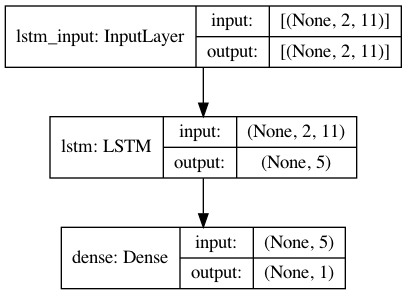

In [31]:
# Alternative Visualization
# Visualize the Network
import tensorflow as tf
tf.keras.utils.plot_model(
    LSTMModel,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

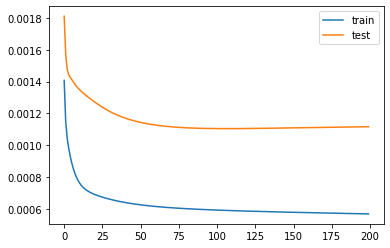

In [32]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [33]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

__compare with previous results__

In [34]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

___Overall Comparison of all the algorithms ( including Time Series Algorithms)___

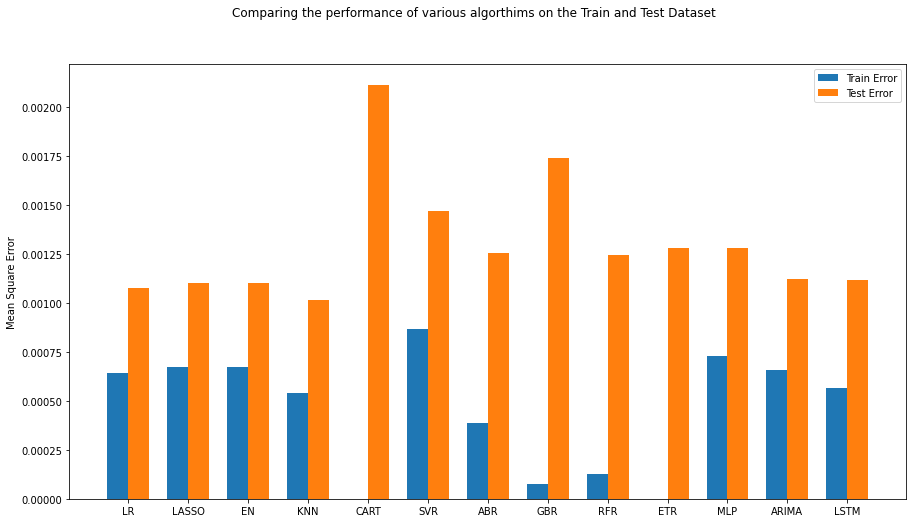

In [35]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

<div class="alert alert-block alert-success">
Looking at the chart above, we find time series based ARIMA model comparable to
the linear supervised-regression models such as Linear Regression (LR), Lasso Regres‐
sion (LASSO) and Elastic Net (EN). This can primarily be due to the strong linear
relationship as discussed before. The LSTM model performs decently, however,
ARIMA model outperforms the LSTM model in the test set. Hence, we select the
ARIMA model for the model tuning.
</div>

__Hyper-parameters Tuning__

In [36]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)   

ARIMA(0, 0, 0) MSE=0.0006580
ARIMA(0, 0, 1) MSE=0.0006517
ARIMA(1, 0, 0) MSE=0.0006555
ARIMA(1, 0, 1) MSE=0.0006448
ARIMA(2, 0, 0) MSE=0.0006251
ARIMA(2, 0, 1) MSE=0.0006231
Best ARIMA(2, 0, 1) MSE=0.0006231


__Final Model and Test-set performance__

In [37]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

In [38]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0011229755707772805


In [39]:
Y_test.head()

2020-03-24    0.061
2020-03-31    0.036
2020-04-07    0.050
2020-04-15    0.009
2020-04-23    0.044
Name: MSFT_dep, dtype: float64

In [40]:
y_test_df = pd.DataFrame(Y_test)
y_test_df = y_test_df.reset_index(drop=True)
y_test_df.head()

,MSFT_dep
0,0.061
1,0.036
2,0.050
3,0.009
4,0.044


In [41]:
pred_test_df = pd.DataFrame(predicted_tuned)
pred_test_df = pred_test_df.reset_index(drop=True)
pred_test_df.head()

,0
0,0.018
1,0.001
2,0.011
3,0.003
4,0.011


In [42]:
print(y_test_df.shape)
print(pred_test_df.shape)

(45, 1)
(45, 1)


In [43]:
y_test_pred = pd.concat([y_test_df,pred_test_df],axis=1)
y_test_pred.head()

,MSFT_dep,0
0,0.061,0.018
1,0.036,0.001
2,0.050,0.011
3,0.009,0.003
4,0.044,0.011


In [44]:
y_test_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MSFT_dep  45 non-null     float64
 1   0         45 non-null     float64
dtypes: float64(2)
memory usage: 848.0 bytes


In [45]:
# Rename the column for forecast
y_test_pred.rename(columns = {0:'FORECAST'}, inplace = True)

In [46]:
y_test_pred.head()

,MSFT_dep,FORECAST
0,0.061,0.018
1,0.036,0.001
2,0.050,0.011
3,0.009,0.003
4,0.044,0.011


__Get the test data and predictions together and calculate the MAPE__

In [47]:
# Calculating MAPE for the last 6 Month's data
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [48]:
mean_absolute_percentage_error(y_test_pred['MSFT_dep'],y_test_pred['FORECAST'])

142.10877392832106

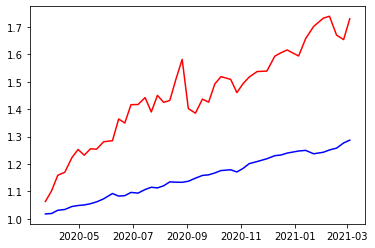

In [49]:
#Use the following code to produce the comparison of actual vs. predicted
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b')
pyplot.rcParams["figure.figsize"] = (8,5)
pyplot.show()

___Another Example___

In [51]:
import numpy as np
import pandas as pd
from numpy import expand_dims
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from keras.layers import Dense,LSTM
from keras.models import Sequential
from keras.optimizers import Adam

In [52]:
pd.set_option('display.max_columns', 10)

In [53]:
data_path = '/Users/shovonsengupta/Desktop/All/EC-Council Course/AI_for_Finance/Section_6_Statistical_Analysis_of_Financial_Time_Series_Data/dataset'

In [56]:
nse_data = pd.read_csv(data_path+'/NSEI.csv')
nse_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-06,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-03-07,10232.95,10243.35,10141.55,10154.20,10154.20,249500.0
2,2018-03-08,10216.25,10270.35,10146.40,10242.65,10242.65,226400.0
3,2018-03-09,10271.30,10296.70,10211.90,10226.85,10226.85,186500.0
4,2018-03-12,10301.60,10433.65,10295.45,10421.40,10421.40,216400.0


In [57]:
nse_data.shape

(248, 7)

In [58]:
nse_data['Date'] = pd.to_datetime(nse_data['Date'], format='%Y-%m-%d', errors='ignore')
nse_data = nse_data[pd.notnull(nse_data['Close'])]
close_price_data = nse_data['Close']
close_price_data_intr = np.array(close_price_data)
close_price_data = expand_dims(close_price_data_intr, axis=1)

In [59]:
close_price_data

array([[10154.200195],
       [10242.650391],
       [10226.849609],
       [10421.400391],
       [10426.849609],
       [10410.900391],
       [10360.150391],
       [10195.150391],
       [10094.25    ],
       [10124.349609],
       [10155.25    ],
       [10114.75    ],
       [ 9998.049805],
       [10130.650391],
       [10184.150391],
       [10113.700195],
       [10211.799805],
       [10245.      ],
       [10128.400391],
       [10325.150391],
       [10331.599609],
       [10379.349609],
       [10402.25    ],
       [10417.150391],
       [10458.650391],
       [10480.599609],
       [10528.349609],
       [10548.700195],
       [10526.200195],
       [10565.299805],
       [10564.049805],
       [10584.700195],
       [10614.349609],
       [10570.549805],
       [10617.799805],
       [10692.299805],
       [10739.349609],
       [10718.049805],
       [10679.650391],
       [10618.25    ],
       [10715.5     ],
       [10717.799805],
       [10741.700195],
       [107

In [60]:
# Scaling continuous variables
scaler = MinMaxScaler()
close_price_data_2 = scaler.fit_transform(close_price_data)

In [61]:
# Parameters
n_inputs = 1
n_outputs = 1
lag_value = 1
n_neurons = 10
n_steps = 4
test_split_ratio_val = 20

In [62]:
# Function to create number of history points and lags to predict variable
def data_prep_lstm(input_data,hist = 1,lag=1):
    x_data = np.zeros((input_data.shape[0]-(lag+hist-1),hist))
    y_data = np.zeros(input_data.shape[0]-(lag+hist-1))
    for i in range((lag+hist-1),(input_data.shape[0]),1):
        y_data[i-(lag+hist-1)] = input_data[i, 0]
        x_data_inter = input_data[(i-(hist+lag-1)):(i-(lag-1)), 0]
        x_data[i-(lag+hist-1),:] = x_data_inter.T
    return x_data,y_data

In [63]:
data_x_val, data_y_val = data_prep_lstm(close_price_data_2,hist=n_steps,lag=lag_value)
data_x_val = data_x_val.reshape((data_x_val.shape[0], data_x_val.shape[1], n_inputs))

In [64]:
data_x_val

array([[[0.08971839],
        [0.14053869],
        [0.13146013],
        [0.243242  ]],

       [[0.14053869],
        [0.13146013],
        [0.243242  ],
        [0.24637292]],

       [[0.13146013],
        [0.243242  ],
        [0.24637292],
        [0.23720908]],

       [[0.243242  ],
        [0.24637292],
        [0.23720908],
        [0.20804996]],

       [[0.24637292],
        [0.23720908],
        [0.20804996],
        [0.1132469 ]],

       [[0.23720908],
        [0.20804996],
        [0.1132469 ],
        [0.05527317]],

       [[0.20804996],
        [0.1132469 ],
        [0.05527317],
        [0.07256732]],

       [[0.1132469 ],
        [0.05527317],
        [0.07256732],
        [0.09032157]],

       [[0.05527317],
        [0.07256732],
        [0.09032157],
        [0.06705173]],

       [[0.07256732],
        [0.09032157],
        [0.06705173],
        [0.        ]],

       [[0.09032157],
        [0.06705173],
        [0.        ],
        [0.07618752]],

       [[0

In [65]:
# Function to split the data
def split_data(_x_data, _y_data,num_perd,test_split_ratio,_xdim, _ydim):
    num_rows = len(_x_data)
    test_split = num_perd *test_split_ratio

    # take data from end
    test_x = _x_data[-test_split:]
    test_y = _y_data[-test_split:]

    remain_x = _x_data[:(num_rows-test_split)]
    remain_y = _y_data[:(num_rows-test_split)]

    train_x = remain_x[(len(remain_x)%num_perd):]
    train_y = remain_y[(len(remain_y)%num_perd):]
    return train_x,test_x,train_y,test_y

In [66]:
x_train, x_test, y_train, y_test = split_data(data_x_val,data_y_val,num_perd =n_steps ,
                                              test_split_ratio=test_split_ratio_val,
                                              _xdim =n_inputs,_ydim = n_outputs)

In [67]:
def LSTM_Model_KS(_n_neurons,_n_steps,_n_inputs):
    model = Sequential()
    model.add(LSTM(_n_neurons,activation='selu',input_shape=(_n_steps,_n_inputs)))
    model.add(Dense(1))
    adam_opt = Adam(lr=0.03)
    # Model compilation
    model.compile(loss='mse',optimizer=adam_opt)
    return model

In [68]:
def LSTM_Multilayer_Model_KS(_n_neurons,_n_steps,_n_inputs):
    model=Sequential()
    model.add(LSTM(_n_neurons,activation='selu',
                   input_shape=(_n_steps,_n_inputs),
                   return_sequences=True))
    model.add(LSTM(_n_neurons,activation='selu',
                   return_sequences=False))
    model.add(Dense(1))
    adam_opt = Adam(lr=0.003)
    # Model compilation
    model.compile(loss='mse',optimizer=adam_opt)
    return model

In [69]:
# Model training
training_epochs = 1000
batch_size = 30

In [70]:
timeseries_model = LSTM_Model_KS(n_neurons,n_steps,n_inputs)

In [71]:
print(timeseries_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


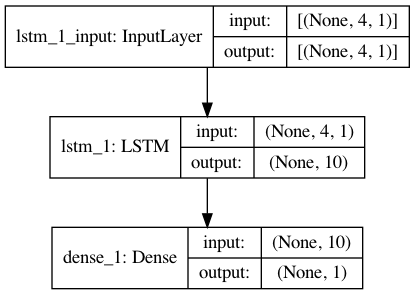

In [97]:
# print the model Architecture
# Alternative Visualization
# Visualize the Network
import tensorflow as tf
tf.keras.utils.plot_model(
    timeseries_model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [72]:
timeseries_model_ml = LSTM_Multilayer_Model_KS(n_neurons,n_steps,n_inputs)

In [73]:
print(timeseries_model_ml.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4, 10)             480       
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
None


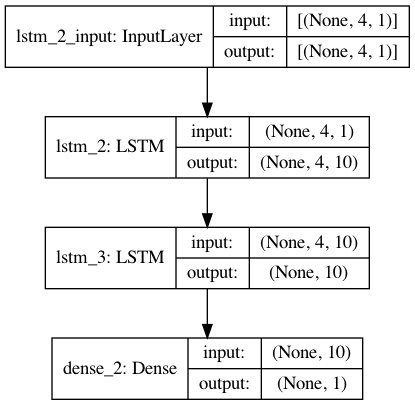

In [98]:
# print the model Architecture
# Alternative Visualization
# Visualize the Network
import tensorflow as tf
tf.keras.utils.plot_model(
    timeseries_model_ml,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [74]:
history = timeseries_model.fit(x_train,
                               y_train,
                               batch_size=batch_size,
                               epochs=training_epochs,
                               validation_data=(x_test, y_test))

Epoch 1/1000
6/6 [==============================] - 1s 48ms/step - loss: 0.0878 - val_loss: 0.0273
Epoch 2/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0251 - val_loss: 0.0177
Epoch 3/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0128 - val_loss: 0.0091
Epoch 4/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0103 - val_loss: 0.0069
Epoch 5/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 6/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0046
Epoch 7/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 8/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0062 - val_loss: 0.0042
Epoch 9/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 10/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 11/100

Epoch 165/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 166/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 167/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 168/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 169/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 170/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 171/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 172/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 173/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 174/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0022


Epoch 328/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 329/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 330/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 331/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 332/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 333/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 334/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 335/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 336/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 337/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0

Epoch 491/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 492/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 493/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 494/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 495/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 496/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 497/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 498/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 499/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 500/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0026

Epoch 573/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 574/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 575/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 576/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 577/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 578/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 579/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 580/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 581/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 582/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.002

Epoch 655/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 656/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 657/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 658/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 659/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 660/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 661/1000
6/6 [==============================] - ETA: 0s - loss: 0.001 - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 662/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 663/1000
6/6 [==============================] - ETA: 0s - loss: 0.002 - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 664/1000
6/6 [==============================

6/6 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 737/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 738/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 739/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 740/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 741/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 742/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 743/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 744/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 745/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 746/1000

6/6 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 819/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 820/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 821/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 822/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 823/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 824/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 825/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 826/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 827/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 828/1000

Epoch 900/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 901/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 902/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 903/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 904/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 905/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 906/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 907/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 908/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 909/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.002

In [75]:
y_pred_train = timeseries_model.predict(x_train)
y_pred_test = timeseries_model.predict(x_test)

In [76]:
# Converting back to original scale of stock price
y_train_2 = expand_dims(y_train, axis=1)
y_train_orig_scale = scaler.inverse_transform(y_train_2)
y_test_2 = expand_dims(y_test, axis=1)
y_test_orig_scale = scaler.inverse_transform(y_test_2)

In [77]:
y_pred_train_orig_scale = scaler.inverse_transform(y_pred_train)
y_pred_test_orig_scale = scaler.inverse_transform(y_pred_test)

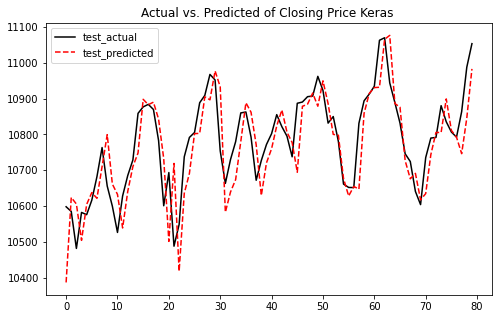

In [78]:
plt.plot(y_test_orig_scale, 'k', label="test_actual")
plt.title("Actual vs. Predicted of Closing Price Keras ")
plt.plot(y_pred_test_orig_scale, 'r--', label="test_predicted")
plt.legend(loc='upper left')
plt.show()

In [79]:
print("Timeseries Train R-squared Keras : ", r2_score(y_train_orig_scale, y_pred_train_orig_scale))
print("Timeseries Test R-squared Keras : ", r2_score(y_test_orig_scale, y_pred_test_orig_scale ))

Timeseries Train R-squared Keras :  0.9847279852896216
Timeseries Test R-squared Keras :  0.584929343724982


In [80]:
y_test_orig_scale_df = pd.DataFrame(y_test_orig_scale)
y_test_orig_scale_df.columns = ['Closing Price']

In [81]:
y_pred_test_orig_scale_df = pd.DataFrame(y_pred_test_orig_scale)
y_pred_test_orig_scale_df.columns = ['Forecasts']

In [82]:
pred = pd.concat([y_test_orig_scale_df,y_pred_test_orig_scale_df],axis=1)
pred.head()

,Closing Price,Forecasts
0,10598.4,10387.391
1,10585.2,10624.277
2,10482.2,10606.021
3,10582.5,10504.705
4,10576.3,10605.016


In [83]:
# Calculate the MAPE
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [84]:
mean_absolute_percentage_error(pred['Closing Price'], pred['Forecasts'])

0.6073084537122809

Text(0.5, 1.0, 'Loss Curves')

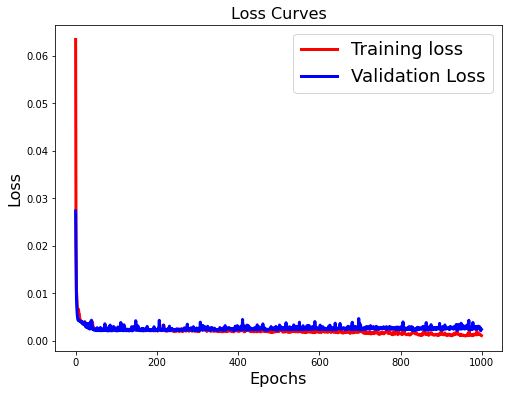

In [85]:
# Loss Curve 
plt.figure(figsize=[8,6])  
plt.plot(history.history['loss'],'r',linewidth=3.0)  
plt.plot(history.history['val_loss'],'b',linewidth=3.0)  
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)  
plt.xlabel('Epochs',fontsize=16)  
plt.ylabel('Loss',fontsize=16)  
plt.title('Loss Curves',fontsize=16)

__Fit the ML model__

In [86]:
history = timeseries_model_ml.fit(x_train,
                        y_train,
                        batch_size=batch_size,
                        epochs=training_epochs,
                        validation_data=(x_test, y_test))

Epoch 1/1000
6/6 [==============================] - 2s 65ms/step - loss: 0.2024 - val_loss: 0.0322
Epoch 2/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0539 - val_loss: 0.0087
Epoch 3/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0298 - val_loss: 0.0257
Epoch 4/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0320 - val_loss: 0.0078
Epoch 5/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0199 - val_loss: 0.0047
Epoch 6/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0171 - val_loss: 0.0047
Epoch 7/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0108 - val_loss: 0.0057
Epoch 8/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0084 - val_loss: 0.0066
Epoch 9/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0080 - val_loss: 0.0056
Epoch 10/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 11/

6/6 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 84/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 85/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 86/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 87/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 88/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 89/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 90/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 91/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 92/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 93/1000
6/6

6/6 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 246/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 247/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 248/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 249/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 250/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 251/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 252/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 253/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 254/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch

6/6 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 408/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 409/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 410/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 411/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 412/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 413/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 414/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 415/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 416/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 417/

6/6 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 570/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 571/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 572/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 573/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 574/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 575/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 576/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 577/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 578/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 579/1000


6/6 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 732/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 733/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 734/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 735/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 736/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 737/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 738/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 739/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 740/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch

6/6 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 894/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 895/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 896/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 897/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 898/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 899/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 900/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 901/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 902/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 

In [87]:
y_pred_train = timeseries_model_ml.predict(x_train)
y_pred_test = timeseries_model_ml.predict(x_test)

In [88]:
# Converting back to original scale of stock price
y_train_2 = expand_dims(y_train, axis=1)
y_train_orig_scale = scaler.inverse_transform(y_train_2)
y_test_2 = expand_dims(y_test, axis=1)
y_test_orig_scale = scaler.inverse_transform(y_test_2)

In [89]:
y_pred_train_orig_scale = scaler.inverse_transform(y_pred_train)
y_pred_test_orig_scale = scaler.inverse_transform(y_pred_test)

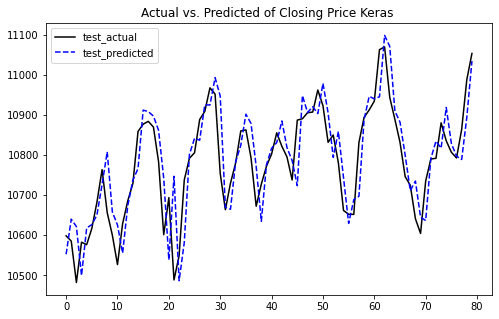

In [90]:
plt.plot(y_test_orig_scale, 'k', label="test_actual")
plt.title("Actual vs. Predicted of Closing Price Keras ")
plt.plot(y_pred_test_orig_scale, 'b--', label="test_predicted")
plt.legend(loc='upper left')
plt.show()

In [91]:
print("Timeseries Train R-squared Keras : ", r2_score(y_train_orig_scale, y_pred_train_orig_scale))
print("Timeseries Test R-squared Keras : ", r2_score(y_test_orig_scale, y_pred_test_orig_scale ))

Timeseries Train R-squared Keras :  0.9672116681135965
Timeseries Test R-squared Keras :  0.6558564735259264


In [92]:
y_test_orig_scale_df = pd.DataFrame(y_test_orig_scale)
y_test_orig_scale_df.columns = ['Closing Price']

In [93]:
y_pred_test_orig_scale_df = pd.DataFrame(y_pred_test_orig_scale)
y_pred_test_orig_scale_df.columns = ['Forecasts']

In [94]:
pred = pd.concat([y_test_orig_scale_df,y_pred_test_orig_scale_df],axis=1)
pred.head()

,Closing Price,Forecasts
0,10598.4,10552.462
1,10585.2,10639.927
2,10482.2,10621.594
3,10582.5,10499.454
4,10576.3,10618.027


In [95]:
mean_absolute_percentage_error(pred['Closing Price'], pred['Forecasts'])

0.5579180928038419

Text(0.5, 1.0, 'Loss Curves')

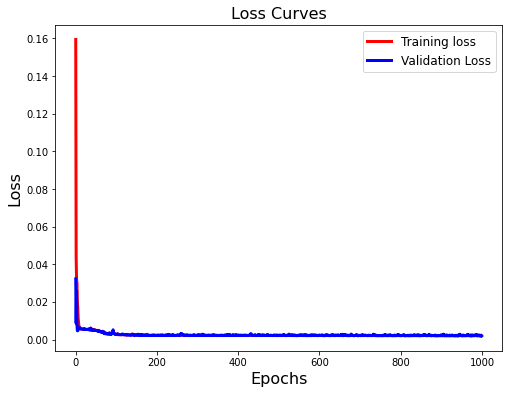

In [96]:
# Loss Curve 
plt.figure(figsize=[8,6])  
plt.plot(history.history['loss'],'r',linewidth=3.0)  
plt.plot(history.history['val_loss'],'b',linewidth=3.0)  
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)  
plt.xlabel('Epochs',fontsize=16)  
plt.ylabel('Loss',fontsize=16)  
plt.title('Loss Curves',fontsize=16)